In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2024-01-30 17:09:37.551666: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 17:09:37.552853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 17:09:37.573076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 17:09:37.573093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 17:09:37.573107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
path_to_file = "/home/alex/dev/AiLearning/DataSetStore/translation/rus.txt"

In [3]:
def preprocess_sentence(w: str) -> str:
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


def read_lines(file_path: str, limit=None) -> list:
    # TODO: Possible random selection or train split here
    return list(io.open(path_to_file, encoding='UTF-8').read().split('\n')[:limit])

def split_by_tab(line_list: list, split_limit=2) -> list:
    result = list()
    for line in line_list:
        splitted_line = line.split('\t')
        if len(splitted_line)>=split_limit:
            result.append(splitted_line[:split_limit])
    return result
    #return [[w for w in line.split('\t')[:split_limit]]  for line in line_list]

def apply_preprocess(line_2d_list: list) -> tuple:
    line_2d_list = [[preprocess_sentence(line) for line in line_list]  for line_list in line_2d_list]
    return zip(*line_2d_list)

def make_preprocessing(file_path: str, line_limit=None):
    return apply_preprocess(
        line_2d_list=split_by_tab(
            line_list=read_lines(
                file_path=file_path,limit=line_limit)))

def tokenize(text_list: list) -> tuple:
  # overriding default filters and building internal courpus
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(text_list)
    
  # building numerical sequence. Each word is coded as the respective corpus number
  tensor = lang_tokenizer.texts_to_sequences(text_list)

  # messages have different lenght. Padding allows to make tensors with same length
  # length difference is compensated by adding ZEROES before or after
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

  return tensor, lang_tokenizer


def load_dataset(file_path: str, line_limit=None):

  targ_lang, inp_lang = make_preprocessing(file_path=file_path,
                                           line_limit=line_limit)

  input_tensor, inp_lang_tokenizer = tokenize(text_list=inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(text_list=targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [4]:
LIMIT = 10000
# Making tensors
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(file_path=path_to_file,line_limit=LIMIT)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
print (example_input_batch.shape, example_target_batch.shape)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print (max_length_targ,max_length_inp)

8000 8000 2000 2000
(64, 12) (64, 8)
8 12


2024-01-30 17:09:44.138611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 17:09:44.151460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 12, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [6]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 12, 1)


In [7]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1734)


In [8]:
# Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


# Checkpoints (Object-based saving)
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [9]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.2680
Epoch 1 Batch 100 Loss 1.7110
Epoch 1 Loss 2.1529
Time taken for 1 epoch 41.12944173812866 sec

Epoch 2 Batch 0 Loss 1.6583
Epoch 2 Batch 100 Loss 1.4366
Epoch 2 Loss 1.5484
Time taken for 1 epoch 35.18496656417847 sec

Epoch 3 Batch 0 Loss 1.2740
Epoch 3 Batch 100 Loss 1.2172
Epoch 3 Loss 1.2887
Time taken for 1 epoch 33.91944456100464 sec

Epoch 4 Batch 0 Loss 1.1850
Epoch 4 Batch 100 Loss 0.9782
Epoch 4 Loss 1.0799
Time taken for 1 epoch 35.06866717338562 sec

Epoch 5 Batch 0 Loss 0.9637
Epoch 5 Batch 100 Loss 0.9693
Epoch 5 Loss 0.9092
Time taken for 1 epoch 33.96410632133484 sec

Epoch 6 Batch 0 Loss 0.7811
Epoch 6 Batch 100 Loss 0.7371
Epoch 6 Loss 0.7590
Time taken for 1 epoch 35.00062370300293 sec

Epoch 7 Batch 0 Loss 0.6188
Epoch 7 Batch 100 Loss 0.5787
Epoch 7 Loss 0.6243
Time taken for 1 epoch 33.94570446014404 sec

Epoch 8 Batch 0 Loss 0.5087
Epoch 8 Batch 100 Loss 0.4830
Epoch 8 Loss 0.5054
Time taken for 1 epoch 35.31659984588623 sec

Epoch 9 

In [11]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [12]:
# docs: https://docs.python-telegram-bot.org/en/stable/examples.echobot.html

from datetime import datetime
import nest_asyncio
nest_asyncio.apply()

from telegram import ForceReply, Update
from telegram.ext import Application, CommandHandler, ContextTypes, MessageHandler, filters


async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Send a message when the command /start is issued."""
    user = update.effective_user
    await update.message.reply_html(
        rf"Hi {user.mention_html()}!",
        reply_markup=ForceReply(selective=True)
    )

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    """Send a message when the command /help is issued."""
    await update.message.reply_text("Help!")

async def make_answer(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    print ("Question: ",update.message.text)
    r,s,a=evaluate(update.message.text)
    print ("Answer: ",r)
    await update.message.reply_text(r)


def main() -> None:
    # Create the Application and pass it your bot's token.
    application = Application.builder().token("6626784673:AAEVV3uyouH-BhMNyyoXEnrEANPDskd-DO4").build()

    # on different commands - answer in Telegram
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("help", help_command))

    # on non command i.e message - echo the message on Telegram
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, make_answer))

    # Run the bot until the user presses Ctrl-C
    application.run_polling(allowed_updates=Update.ALL_TYPES)




In [ ]:
if __name__ == "__main__":
    main()

Question:  идти
Answer:  do you go ! <end> 
Question:  иду
Answer:  i'm coming . <end> 
Question:  читаю
Answer:  i'm sorry . <end> 
Question:  ем
Answer:  i'm working . <end> 
Question:  сплю
Answer:  terrific ! <end> 


No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "/home/alex/ai_learn_env/lib/python3.11/site-packages/telegram/ext/_application.py", line 1234, in process_update
    await coroutine
  File "/home/alex/ai_learn_env/lib/python3.11/site-packages/telegram/ext/_basehandler.py", line 157, in handle_update
    return await self.callback(update, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_13218/166713138.py", line 25, in make_answer
    r,s,a=evaluate(update.message.text)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_13218/346849971.py", line 5, in evaluate
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_13218/346849971.py", line 5, in <listcomp>
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
              ~~~~~~~~~~~~~~~~~~~^^^
KeyError: 'гляжу'


Question:  гляжу
Question:  вижу
Answer:  may i hurry ? <end> 
Question:  На помощь
Answer:  this is ? <end> 
Question:  Пригнись
Answer:  duck ! <end> 
Question:  Здорово
Answer:  that's closed . <end> 
Question:  Кто
Answer:  who are men . <end> 
Question:  Приветик
Answer:  hello . <end> 
Question:  Здорово
Answer:  that's closed . <end> 
Question:  Идите
Answer:  go of <end> 
Question:  пожар
Answer:  fire ! <end> 
Question:  спасите
Answer:  i got lucky . <end> 
Question:  помоги
Answer:  help fixed . <end> 
Question:  прячься
Answer:  hurry up . <end> 
Question:  остановись
Answer:  stop ! <end> 
Question:  подожди
Answer:  how quit ? <end> 
Question:  начинай
Answer:  shut up . <end> 
Question:  ого
Answer:  that's lame . <end> 
Question:  я побежал
Answer:  i swore . <end> 
Question:  понимаю
Answer:  where is it ? <end> 
Question:  как быть
Answer:  how strange ! <end> 
Question:  быть или не быть
Answer:  it's hailing . <end> 


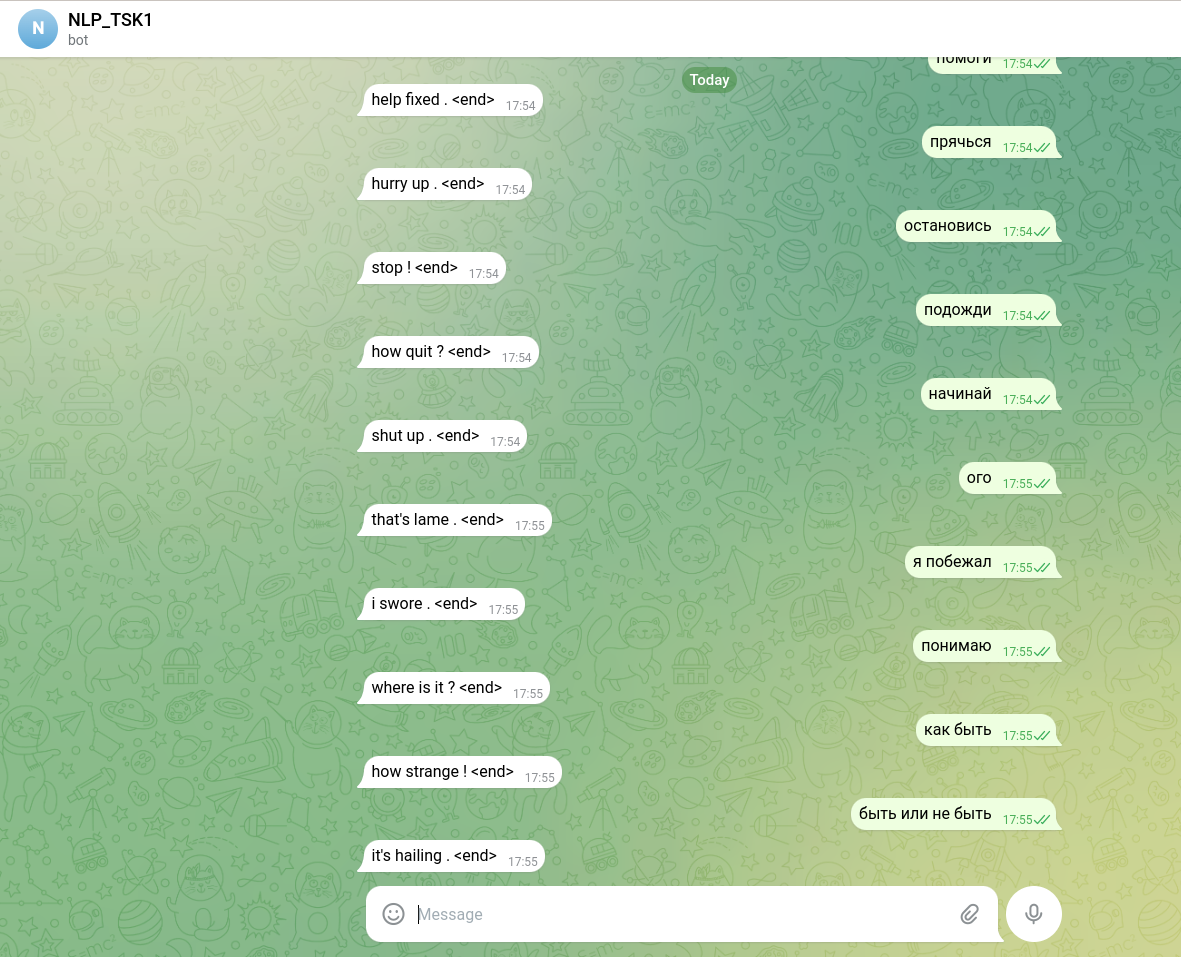